In [1]:
!rm -rf /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


 Training: EfficientNetB0

Epoch 1/18 | Train Loss = 2.5461 | Val Loss = 2.9069 | Val Acc = 0.5700
>>> Best model saved!
Epoch 2/18 | Train Loss = 2.2589 | Val Loss = 2.8726 | Val Acc = 0.5600
Epoch 3/18 | Train Loss = 2.0769 | Val Loss = 2.3548 | Val Acc = 0.6100
>>> Best model saved!
Epoch 4/18 | Train Loss = 1.8668 | Val Loss = 2.1294 | Val Acc = 0.6100
Epoch 5/18 | Train Loss = 1.6437 | Val Loss = 1.9906 | Val Acc = 0.6400
>>> Best model saved!
Epoch 6/18 | Train Loss = 1.4640 | Val Loss = 1.9041 | Val Acc = 0.6500
>>> Best model saved!
Epoch 7/18 | Train Loss = 1.5277 | Val Loss = 1.7582 | Val Acc = 0.6800
>>> Best model saved!

>>> Fine-tuning started! Unfroze entire model.

Epoch 8/18 | Train Loss = 1.2161 | Val Loss = 0.9633 | Val Acc = 0.8200
>>> Best model saved!
Epoch 9/18 | Train Loss = 0.3334 | Val Loss = 0.8415 | Val Acc = 0.8500
>>> Best model saved!
Epoch 10/18 | Train Loss = 0.1250 | Val Loss = 0.7183 | Val Acc = 0.8700
>>> Best model saved!
Epoch 11/18 | Train Loss =

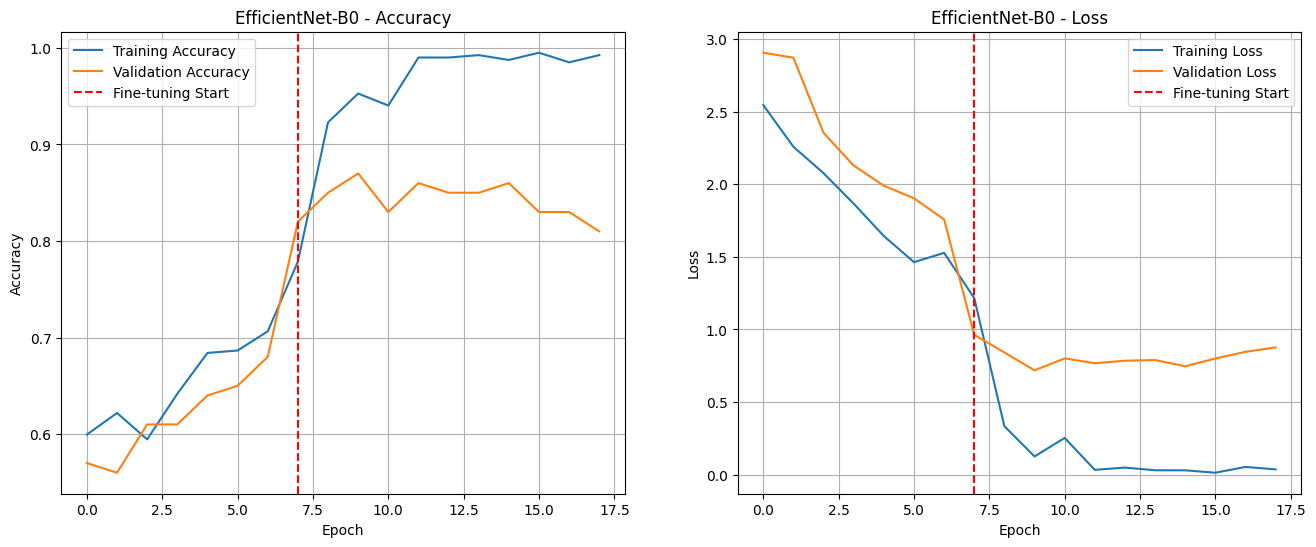

In [1]:
# ====================================================
# INSTALL & IMPORTS
# ====================================================
!pip install timm --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import os

# ====================================================
# PATHS
# ====================================================
train_dir = "/content/drive/MyDrive/my_dataset1/my_dataset/train"
test_dir  = "/content/drive/MyDrive/my_dataset1/my_dataset/test"
save_folder = "/content/drive/MyDrive/models/EfficientNetB0"
os.makedirs(save_folder, exist_ok=True)

# ====================================================
# DATA TRANSFORMS
# ====================================================
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ====================================================
# DATA LOADERS
# ====================================================
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir , transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ====================================================
# MODEL (EfficientNet-B0)
# ====================================================
num_classes = 2

model = timm.create_model(
    'efficientnet_b0',
    pretrained=True,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

fine_tune_epoch = 7  # red line

# Freeze backbone before fine-tuning
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


# ======================================================
# STORAGE LISTS FOR GRAPH (IMPORTANT)
# ======================================================
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0

# ====================================================
# TRAINING LOOP
# ====================================================
epochs = 18
print("\n========================")
print(" Training: EfficientNetB0")
print("========================\n")

for epoch in range(epochs):

    # ----------- Unfreeze at fine-tuning point ----------
    if epoch == fine_tune_epoch:
        for param in model.parameters():
            param.requires_grad = True
        print("\n>>> Fine-tuning started! Unfroze entire model.\n")
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # ================= TRAIN =================
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ================= VALIDATION =================
    model.eval()
    running_vloss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_vloss += loss.item() * imgs.size(0)

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    avg_val_loss = running_vloss / len(test_loader.dataset)
    val_acc = correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val Acc = {val_acc:.4f}")

    # Save Best Model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), f"{save_folder}/best_effnet_model.pth")
        print(">>> Best model saved!")

# ====================================================
# PLOT LOSS & ACCURACY (LIKE INCEPTION-V3)
# ====================================================
plt.figure(figsize=(16,6))

# ---------------- ACCURACY PLOT ----------------
plt.subplot(1,2,1)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.axvline(x=fine_tune_epoch, color='red', linestyle='--', label="Fine-tuning Start")
plt.title("EfficientNet-B0 - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# ---------------- LOSS PLOT ----------------
plt.subplot(1,2,2)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.axvline(x=fine_tune_epoch, color='red', linestyle='--', label="Fine-tuning Start")
plt.title("EfficientNet-B0 - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()
